## NVIDIA Nsight Systems
[NVIDIA Nsight™ Systems](https://developer.nvidia.com/nsight-systems) is a system-wide performance analysis tool designed to visualize an application’s algorithms, help to identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs.

## NVIDIA Tools Extension (NVTX)

The [NVIDIA® Tools Extension Library (NVTX)](https://github.com/NVIDIA/NVTX) is a powerful mechanism that allows users to manually instrument their application. With a C-based and a python-based Application Programming Interface (API) for annotating events, code ranges, and resources in your applications. Applications which integrate NVTX can use NVIDIA Nsight, Tegra System Profiler, and Visual Profiler to capture and visualize these events and ranges. In general, the NVTX can bring valuable insignt into the application while incurring almost no overhead. 


## MONAI Transforms and NVTX
[MONAI](https://github.com/Project-MONAI/MONAI) is a high level framework for deep learning in healthcare imaging. One of its core concepts is [Transforms](https://github.com/Project-MONAI/MONAI/tree/dev/monai/transforms), similar to [TorchVision Transfoms](https://pytorch.org/vision/stable/transforms.html). Several of these transfoms are usualy chained together, using a [Compose](https://github.com/Project-MONAI/MONAI/blob/2f1c7a5d1b47c8dd21681dbe1b67213aa3278cd7/monai/transforms/compose.py#L35) class, to create a preprocessing or postprocessing pipeline that performs manipulation of the input data and make it suitable for training a deep learning model or inference. Using this chain of tranformaion does not allow for insertion of NVTX annotation directly in the code and may require modification of the source code. On the other hand, [MONAI NVTX Tranforms]() are a flexible way to insert the annotations in the chain of transforms by simplly adding additional tranforms that cause vitually no-overhead and does not alter the code.


## Profiling Digital Pathology Tumor Detection Pipeline

In [1]:
!PYTHONPATH=${HOME}/workspace/MONAI/:${PYTHONPATH} && \
    nsys profile \
        --trace nvtx,osrt,cudnn,cuda, \
        --delay 30 \
        --duration 60 \
        --show-output true \
        --force-overwrite true \
        --output profile_report \
        python camelyon_train_evaluate_nvtx_profiling.py --cpu 0

{'dataset_json': '../dataset_0.json', 'data_root': '/workspace/data/medical/pathology/', 'logdir': './logs/', 'region_size': 768, 'grid_shape': 3, 'patch_size': 224, 'batch_size': 64, 'n_epochs': 10, 'lr': 0.001, 'use_openslide': False, 'amp': True, 'novograd': True, 'pretrain': True, 'num_workers': 0, 'gpu': '0'}
Logs and model are saved at './logs/210811-005649_resnet18_ps224_bs64_ep10_lr0.001'.
CUDA is being used with GPU ID(s): 0
[Plugin: cucim.kit.cuslide] Loading...
[Plugin: cucim.kit.cuslide] Loading the dynamic library from: /opt/conda/lib/python3.8/site-packages/cucim/clara/cucim.kit.cuslide@0.19.0.so
[Plugin: cucim.kit.cuslide] loaded successfully. Version: 0
Initializing plugin: cucim.kit.cuslide (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cuslide)
image: 
    shape torch.Size([576, 3, 224, 224])
    type:  <class 'torch.Tensor'>
    dtype:  torch.float32
labels: 
    shape torch.Size([576, 1, 1, 1])
    type:  <class 'torch.Tensor'>
    dtype:  torch.float

In [2]:
!nsys stats \
    --report nvtxppsum,nvtxppsum,nvtxpptrace \
    --format table,csv \
    --output -,. \
    --force-overwrite true \
    profile_report.qdrep

Generating SQLite file profile_report.sqlite from profile_report.qdrep
Exporting 585319 events: [================================================100%]
Using profile_report.sqlite for SQL queries.
Running [/usr/local/cuda-11.4/NsightSystems-cli-2021.2.4/target-linux-x64/reports/nvtxppsum.py profile_report.sqlite]... 

+---------+-----------------+-----------+------------+----------+-----------+------------+----------------------+
| Time(%) | Total Time (ns) | Instances |  Average   | Minimum  |  Maximum  |   StdDev   |        Range         |
+---------+-----------------+-----------+------------+----------+-----------+------------+----------------------+
|    50.0 |    384798241392 |      7398 | 52013820.1 | 35315381 | 819145629 | 32473319.7 | Preprocessing        |
|    41.1 |    316840832965 |      7398 | 42827903.9 | 35215964 | 801440587 | 31478026.4 | ColorJitter          |
|     4.3 |     33475960513 |      7398 |  4525001.4 |  3857418 | 187606192 |  6474106.2 | RandZoomD           

# Performance Analysis

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Ordered list of NVTX range for all training transforms
transforms = [
    "ToTensorD_1",
    "ColorJitter",
    "ToNumpyD",
    "RandFlipD",
    "RandRotate90D",
    "CastToTypeD",
    "RandZoomD",
    "ScaleIntensityRangeD",
    "ToTensorD_2",
    "ActivationsD",
    "AsDiscreteD",
]

## Using Nsight Summary Report

In [5]:
# Load NVTX Push/Pop Range Summary
summary = pd.read_csv("profile_report_nvtxppsum.csv")
# display(summary)

# Set the Range (which is the name of each range) as the index
summary.set_index("Range", inplace=True)

# Get the entries for training transforms only (to avoid nested ranges)
summary = summary.loc[transforms]

# Normalize each transform range with total average time (percentage of transfom time)
summary = summary[["Average", "Minimum", "Maximum", "StdDev"]] / summary["Average"].sum() * 100
summary

,Average,Minimum,Maximum,StdDev
Range,,,,
ToTensorD_1,0.168601,0.133038,2.157495,0.103382
ColorJitter,82.357432,67.719783,1541.158518,60.531784
ToNumpyD,1.151550,1.066907,2.847964,0.097108
RandFlipD,0.611765,0.540692,1.503676,0.053035
RandRotate90D,0.670665,0.589989,1.610025,0.065138
CastToTypeD,0.860989,0.635866,1.921612,0.097279
RandZoomD,8.701511,7.417758,360.763961,12.449611
ScaleIntensityRangeD,4.645228,4.241479,10.469321,0.380967
ToTensorD_2,0.715904,0.594537,2.665981,0.125217


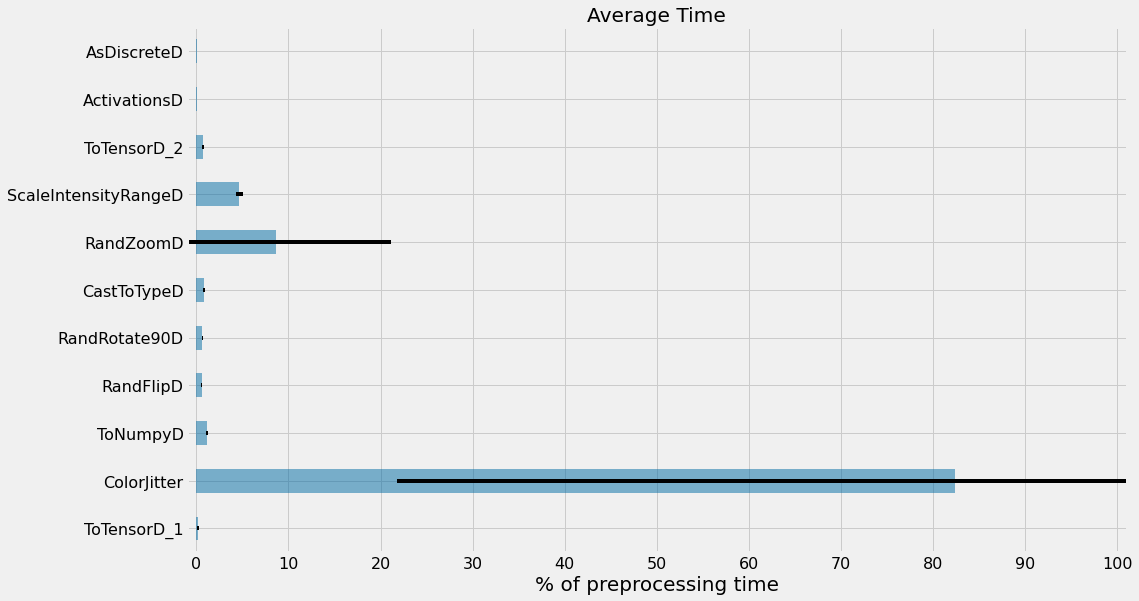

In [6]:
plt.style.use("fivethirtyeight")
plt.style.use("tableau-colorblind10")
axes = summary.plot.barh(
    y="Average",
    xerr='StdDev',
    title='Average Time',
    xlabel='',
    fontsize=16,
    figsize=(15, 9),
    alpha=0.5,
    legend="",
)
axes.set_xlim([-1, 101])
axes.set_xticks(range(0, 101, 10))
axes.set_xlabel('% of preprocessing time', fontsize=20)

Text(0.5, 0, '% of preprocessing time')

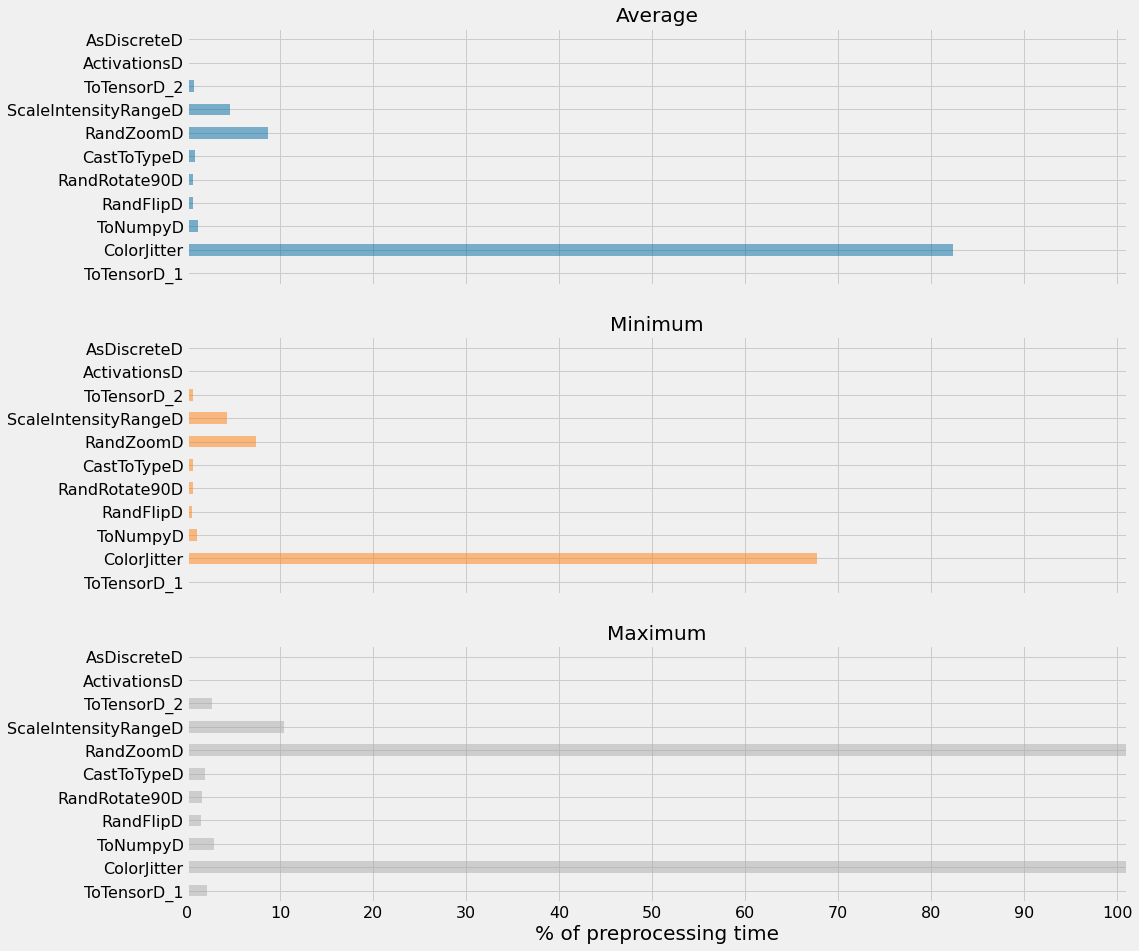

In [7]:
axes = summary.plot.barh(
    y=["Average", "Minimum", "Maximum"],
    xlabel='',
    fontsize=16,
    figsize=(15, 15),
    alpha=0.5,
    subplots=True,
    legend="",
)
axes[-1].set_xlim([0, 101])
axes[-1].set_xticks(range(0, 101, 10))
axes[-1].set_xlabel('% of preprocessing time', fontsize=20)
